In [1]:
using LinearAlgebra
using Plots
using Distributions
using Statistics
using Interpolations
using Images

# Datos iniciales

In [2]:
TableC99AF1B = [split(fila, " ") for fila in split(read("C99AF1B.TXT", String), "\r\n")]
DatI = zeros(4800,6)
for i=1:4800
	for j=1:6
		DatI[i,j]=parse(Float64,TableC99AF1B[i,:][1][j])
	end
end	

# Modelo TOMGRO en función de parámetros

In [3]:
function TOMGROV2(p)
    #************************************************************************************************************
    #************************************************************************************************************
    #Parámetros variables
    Q10 = p 

    #************************************************************************************************************
    #************************************************************************************************************
    #Cultivo: parámetros fijos
    
    XK = 0.58
    XM = 0.091
    CK = -0.8
    VPDL = 3.0
    QE = 0.0645
    TAU1 = 0.0693
    TPL = 0.336
    EPS = 1e-12
    GREF = 0.75
    FPNPT = 1.23
    ABORMX = 0.73
    #Q10 = 1.4
    RMRL = 0.015
    RMRF = 0.01
    FTRUSN = 9.64
    SLAMX = 0.06
    FRLG = 9.33
    FRPT = 0.277
    FRST = 0.418
	
    BOX = [0.0, 5.0, 15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0, 95.0, 100.0]
    POL = [0.0, 0.00141, 0.00345, 0.00505, 0.00536, 0.00465, 0.00357, 0.00253, 0.00171, 0.00112, 0.00072, 0.0]
    POF = [0.0, 0.022, 0.116, 0.296, 0.476, 0.539, 0.508, 0.420, 0.319, 0.229, 0.159, 0.0]

    NBFPT = 5.0*ones(100)
    NBFPT[1] = 4.0

    PGRED = [0.0, 0.67, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
    TMPG = [0.0, 9.0, 12.0, 15.0, 21.0, 28.0, 35.0, 50.0]
    GENTEM = [0.0, 0.0, 0.53, 1.0, 0.0, 0.0]
    XTEM = [0.0, 5.0, 10.0, 28.0, 50.0, 51.0]
    GENRAT = [0.69, 0.69, 0.60, 0.50, 0.41, 0.32, 0.32, 0.32]
    XGEN = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0]
    RDVLVT = [0.0, 0.0, 0.0085, 0.0288, 0.0288, 0.0, 0.0, 0.0, 0.0]
    XLV = [0.0, 5.0, 10.0, 28.0, 35.0, 50.0, 51.0, 52.0, 53.0]
    RDVFRT = [0.0, 0.0, 0.00893, 0.0232, 0.0232, 0.0, 0.0, 0.0, 0.0]
    XFR = [0.0, 5.0, 10.0, 28.0, 35.0, 50.0, 51.0, 52.0, 53.0]
    PROOT = [0.2, 0.1, 0.07, 0.07, 0.07, 0.07]
    XROOT = [0.0, 20.0, 30.0, 45.0, 50.0, 60.0]
    PLETEM = [0.0, 0.0, 0.8, 1.0, 1.0, 0.0]
    TEMPLE = [0.0, 12.0, 17.0, 28.0, 35.0, 50.0]
    SLAM = [0.0, 0.0120, 0.0275, 0.0520, 0.0520, 0.0520]
    TEMSLA = [12.0, 15.6, 20.4, 28.0, 35.0, 50.0]

    #************************************************************************************************************
    #************************************************************************************************************
    #Variables de ajuste de condiciones iniciales y del ciclo
    
    NSTART = 25
    NDAYS = 140
    DELT = 1.0
    NFAST = 24
    INTOUT = 1
    TRGH = 0.473
    PLM2 = 2.5
    PLSTNI = 18.77
    WLVSI = 8.66
    PLARI = 0.187
    WSTMI = 3.56

    #************************************************************************************************************
    #************************************************************************************************************
    #Inicialización de variables

    
    DTFAST = 1.0 / NFAST
    # número de frutas "abortadas", ajuste de frutas y su cantidad total	
    TABF = 0
    TNSF = 0
    TNF = 0


    DWL = zeros(100)
    XLA = zeros(100)
    DWS = zeros(100)
    AGLS = zeros(100)
    ABOR = zeros(100)
    XNFT = zeros(100)
    DWTR = zeros(100)
    PLE = zeros(100)
    PGL = zeros(100)
    PGS = zeros(100)
    ABNF = zeros(100)
    NSF = zeros(100)
	

    RCNF = zeros(100)

    # Todas las variables en la primera etapa de siembra (primer florecimiento de racimo) PRIMERA SECCIÓN
    DWL[1] = WLVSI * 0.83
    AGLS[1] = 1.0
    DWS[1] = WSTMI * 0.93
    DWTR[1] = 0
    XLA[1] = PLARI * 0.85
    ABOR[1] = 0
    XNFT[1] = 0
    DWTR[1] = 0
    # Todas las variables en la primera etapa de siembra (segundo florecimiento de racimo) SEGUNDA SECCIÓN
    DWL[2] = WLVSI * 0.17
    AGLS[2] = 0.9
    DWS[2] = WSTMI * 0.07
    DWTR[2] = 0.0
    XLA[2] = PLARI * 0.15
    ABOR[2] = 0
    XNFT[2] = 0
    DWTR[2] = 0
    # La edad del órgano en la fecha inicial es muy importante para el peso final de los primeros órganos
    DWF = zeros(100, 7)
    AGF = zeros(100, 7)
    PGF = zeros(100, 7)


    # Establecer las condiciones iniciales por planta
    PLSTN = PLSTNI
    PLAR = PLARI
    PLAR2 = PLARI
    # CPOOL se supone que empieza en un 5% del peso seco de las hojas 
    CPOOL = 0.05 * WLVSI
    TDML = WLVSI
    TDML2 = WLVSI
    TDMS = WSTMI
    TDMF = 0
    DMGF = 0
    DMGL = WLVSI

    # Datos necesarios para correr el modelo
    RefIntClim = DatI

    results = zeros(NDAYS, 33)
    RCDRW = 0.0
    SOSIR = 0.0
    GRESP = 0.0
    TRESP = 0.0

    #************************************************************************************************************
    #************************************************************************************************************
    # Ejecución del TOMGRO
    
    # Ciclo diario
    for JDAY in 1:NDAYS
        TIME = (JDAY - 1) * DELT
        DATE = mod(TIME + NSTART, 365)

    # Inicializar variables que se acumulan a lo largo del día
        GP = 0
        TEMFAC = 0
        RMAINT = 0
        RDVLV = 0
        RDVFR = 0
        TEMEXP = 0
        SLAMIN = 0
    
    #************************************************************************************************************
    #************************************************************************************************************
    # Ciclo horario
        for JF in 1:NFAST
        # TFAST es la hora del día (h)
            TFAST = (JF - 1) * 24 / NFAST

        # Insertar datos horarios del clima
            d = findall(x -> x[1] == DATE && x[2] == (TFAST + 1), eachrow(RefIntClim))
            if length(d) > 1
                println("more than 1 found!!")
            end
            if isempty(d)
                println("invalid index of climate data")
            end

            d = d[1]

        
            JUL = RefIntClim[d, 1]
            IHE = RefIntClim[d, 2]
            solrad = RefIntClim[d, 3]
            TMPA = RefIntClim[d, 4]
            VPD = RefIntClim[d, 5]
            CO2L = RefIntClim[d, 6]
            PAR = solrad * TRGH
            PPFD = PAR * 4.57
        #************************************************************************************************************
        # Cálculo de la tasa de desarrollo 
            TEMFCF = LinearInterpolation(XTEM, GENTEM).(TMPA)
            TEMEXP1 = LinearInterpolation(TEMPLE, PLETEM).(TMPA)
            SLAMIN1 = LinearInterpolation(TEMSLA, SLAM,extrapolation_bc=Line()).(RefIntClim[d, 4])
            RDVLVF = LinearInterpolation(XLV, RDVLVT).(TMPA)
            RDVFRF = LinearInterpolation(XFR, RDVFRT).(TMPA)

        #************************************************************************************************************
        # Cálculo de la fotosíntesis gruesa
            GPF = 0
        # Efecto del CO2 en Pmax
            TAU2 = 0.03
            PMAX = TAU1 * CO2L
            if CO2L > 1500
                PMAX = (TAU1 * 1500) + (TAU2 * (CO2L - 1500))
            end
            PMAX *= LinearInterpolation(TMPG,PGRED)(TMPA[1])

            if PPFD >= 0.001
                if VPD >= VPDL
                # Reducción de Pmax por VPD
                    PMAX *= exp(CK * (VPD - VPDL))
                end
            # Modelo de Acock
                TOP = (1 - XM) * PMAX + QE * XK * PPFD
                BOT = (1 - XM) * PMAX + QE * XK * PPFD * exp(-XK * PLAR2 * PLM2)
                GPF = (PMAX / XK) * log(TOP / BOT)
            
                GPF *= 0.682  # conversion desde CO2 a CH2O (30/44 = 0.682)
                GPF *= 3.8016 / PLM2  # conversion de GPF desde M/m2 a g/m2-día
            end

        #************************************************************************************************************
        # Cálculo de la respiración de mantenimiento
            RMAINTF = (RMRL * (TDML2 + TDMS) + RMRF * DMGF) * (Q10 ^ (0.1 * TMPA - 2.0))

        #************************************************************************************************************
        # Integración de las variables en 24 horas
            TEMFAC += TEMFCF * DTFAST
            TEMEXP += TEMEXP1 * DTFAST
            SLAMIN += SLAMIN1 * DTFAST
            RMAINT += RMAINTF * DTFAST
            RDVLV += RDVLVF * DTFAST
            RDVFR += RDVFRF * DTFAST
            GP += GPF * DTFAST
        end 
    #Finalización del ciclo horario
    #************************************************************************************************************
    #************************************************************************************************************



    
    #************************************************************************************************************
    # Desarrollo y fuerza de hundimiento
    
        # Número de nodo
        GENR = TEMFAC*LinearInterpolation(XGEN, GENRAT,extrapolation_bc=Line()).(PLSTN)
        PLSTN += GENR

        # Número de racimo
        NBRU = floor((PLSTN - FTRUSN + (1 + TPL) / TPL) * TPL / (1 + TPL))
        NBRU = max(0, NBRU)

        # Número de racimo produciendo frutas
        NBRUP = floor((PLSTN - FTRUSN - FRLG + (1 + TPL) / TPL) * TPL / (1 + TPL))
        NBRUP = max(0, NBRUP)

        # Número de hojas
        NBLV = floor(PLSTN) - NBRU

        # Número de frutas (díametro > 20mm) en cada racimo
        # Nota: FPN es ahora la razón de iniciación de fruta en un racimo por nodo de iniciación
        TRCNF = 0

        if NBRUP == 0
            NBRUP_length = -1
        else
            NBRUP_length = 1:NBRUP
        end
    
        for I in NBRUP_length
            I = Int(I)
            XX = XNFT[I]
            # FPN ahora es reemplazado por FPNPT = 0.8
            XNFT[I] = min(NBFPT[I], XNFT[I] + GENR * FPNPT)
            RCNF[I] = XNFT[I] - XX
            TRCNF += RCNF[I]
            # rncf(i) y trcnf son utilizados en el ajuste de fruta
        end
        TNF += TRCNF

    #************************************************************************************************************
    # Envejecimiento y fuerza de hundimiento (determinado para hojas, tallos y para cada fruta por cada unidad reproductiva)
        PTNLVS = 0
        PTNSTM = 0
        PTNFRT = 0

    # Hojas y tallos
    # nuevas hojas empiezan a envejecer cuando un nuevo racimo aparece (2 hojas abajo y 1 hoja arriba)
        for I in 1:NBRU
            I = Int(I)
            if AGLS[I] == -EPS
                PLE[I] = 0
                PGL[I] = 0
                PGS[I] = 0
            else
                # cuando se poda la hoja, no se asigna más biomasa ni a las hojas ni a los tallos de la misma unidad reproductiva
                AGLS[I] = min(1, AGLS[I] + RDVLV)
                XBOX = 100 * AGLS[I]
            # PLE(I) es el radio de expansión de hojas potencial
            # la primer unidad reproductiva tiene FTRUSN hojas, otras (1 .+ TPL)/TPL
            # 5/10/95:  remplazo de (1 .+ TPL)/TPL por 1/TPL
            if I == 1
                PLE[I] = TEMFAC * max(0, LinearInterpolation(BOX, POL)(XBOX)) * FTRUSN
            elseif I < 3
                PLE[I] = TEMFAC * max(0, LinearInterpolation(BOX, POL)(XBOX)) / TPL
            else
                PLE[I] = TEMEXP * max(0, LinearInterpolation(BOX, POL)(XBOX)) / TPL
            end
            PGL[I] = PLE[I] * (1 + FRPT) / SLAMIN
            PGS[I] = PGL[I] * FRST
            end
            PTNLVS += PGL[I] 
            PTNSTM += PGS[I]
        end  # final ciclo

    # Fruta
        for I in 1:NBRU
            I = Int(I)
            for J in 1:floor(XNFT[I])
                J = Int(J)
                AGF[I, J] = min(1, AGF[I, J] + RDVFR)
                XBOX = 100 * AGF[I, J]
                if length(DWF[I, J]) == 0
                    PGF[I, J] = 0
                else
                    if DWF[I, J] < 0
                        PGF[I, J] = 0
                    else
                        PGF[I, J] = TEMFAC * max(0, LinearInterpolation(BOX, POF)(XBOX))
                        PTNFRT += PGF[I, J]
                    end
                end
            end
        end

    # Demanda de hundimiento total
        PNGP = PTNLVS + PTNSTM + PTNFRT
    #************************************************************************************************************
    #************************************************************************************************************

    # Producción diaria de biomasa
    
        RCDRW = GREF * (GP + CPOOL - RMAINT)
        if RCDRW < 0
            RCDRW = 0
            RMAINT = GP + CPOOL
        end
        RCDRW *= 1 .- LinearInterpolation(XROOT, PROOT,extrapolation_bc=Line()).(PLSTN)

    # Cálculo de la razón entre oferta y demanda
        SOSIR = min(1, RCDRW / (PNGP + EPS))

    # Respiración de crecimiento diaria
        GRESP = ((PNGP * SOSIR) / GREF) * (1 - GREF * 1.125)
        # 1.125 es (30/12)*0.45 para convertir GREF desde gDM/gCH2O a gCH2O/gCH2O 
    
    # Respiración diaria total
        TRESP = RMAINT + GRESP

    #************************************************************************************************************
    #************************************************************************************************************
    
    # Ajuste de fruta
    
        TABNF = 0
        if TDMF < EPS
            dummy = 0
        else
            FABOR = min(1, (0.67 - ABORMX * SOSIR))
            FABOR = max(0, FABOR)
            TABNF = FABOR * TRCNF
        end

        TABF += TABNF
        TNSF = TNF - TABF

    # Ubicación de las frutas "abortadas": posición distal
        B = 0
        for I in 1:NBRUP
            I = Int(I)
            # Si no hay nuevos frutos, o hay menos de dos frutos en el racimo I o no hay más aborto de frutos
            if RCNF[I] == 0 || XNFT[I] <= 2 || B >= TABNF
                dummy = 0
            else
                ABNF[I] = min(4, RCNF[I], TABNF - B, XNFT[I] - 2 - ABOR[I])
                ABNF[I] = max(0, ABNF[I])
                B += ABNF[I]
                ABOR[I] += ABNF[I]
                NSF[I] = floor(XNFT[I] - ABOR[I])
                # Nótese que esto conduce a 2 frutos abortados para ABOR = 1.1
            
                if ABOR[I] < 1
                    dummy = 0
                else
                    for J in NSF[I] + 1:floor(XNFT[I])
                        J = Int(J)
                        DWF[I, J] = -EPS
                    end
                end
            end
        end

    #************************************************************************************************************
    #************************************************************************************************************

    # Particionamiento de materia seca

    
        ASCSP = 0
        TDML = 0
        TDML2 = 0
        DMGL = 0
        TDMS = 0
        TDMF = 0
        DMGF = 0
        TNMF = 0
        DMMF = 0
        PLAR = 0
        PLAR2 = 0

    # Peso seco de hojas
        for I in 1:NBRU
            I = Int(I)
            J = I + 1
            ASC = min(PGL[I], PGL[I] * SOSIR)
            ASCSP += ASC
            DWL[I] += ASC

            # Peso seco de hojas en crecimiento
            if AGLS[I] < 1
                DMGL += DWL[I]
            end

            # Ahora la expansión del área de las hojas es potencial o está limitada por un SLA máximo
            # Está disponible para cada unidad
            XLA[I] += min(PLE[I], (ASC * SLAMX / (1 + FRPT)))
            TDML += DWL[I]
        
            # Área total de hojas
            PLAR += XLA[I]
            # total menos hojas podadas (hojas podadas al cosechar el racimo)
            if AGLS[I] > 0
                PLAR2 += XLA[I]
                TDML2 += DWL[I]
            end

            #  cuando se cosecha el racimo, también se poda la mitad de las hojas superiores
            if AGLS[I] < 0
                if AGLS[J] > 0
                    PLAR2 -= XLA[J] + XLA[J]
                    TDML2 -= DWL[J] + DWL[J]
                end
            end
        end

    # Peso seco de tallos
        for I in 1:NBRU + 1
            I = Int(I)
            ASC = min(PGS[I], PGS[I] * SOSIR)
            ASCSP += ASC
            DWS[I] += ASC
            TDMS += DWS[I]
        end

    # Peso seco de las frutas
        TDMF = 0
        ASC = 0
        for I in 1:NBRU
            I = Int(I)
            DWTR[I] = 0
            NFT = floor(XNFT[I])
            for J in 1:NFT
                J = Int(J)
                # Para fruta "abortada", DWF = -EPS
                if J == 0
                    dummy = 0
                else
                    if AGF[I, J] < 1 && DWF[I, J] >= 0
                        ASC = min(PGF[I, J], PGF[I, J] * SOSIR)
                        ASCSP += ASC
                        DWF[I, J] += ASC
                    end
                
                    if DWF[I, J] > 0
                        DWTR[I] += DWF[I, J]
                    end
                
                    # Fruta madura
                    if AGF[I, J] == 1 && DWF[I, J] > 0
                        DMMF += DWF[I, J]
                        TNMF += 1
                    end
                
                    if AGF[I, J] < 1 && DWF[I, J] > 0
                    DMGF += DWF[I, J]
                    end
                end
            end

            # Poda de las hojas (cuando se cosecha el racimo)
            # la edad de las hojas podadas se fija en -EPS para ser identificadas
            if AGF[I, Int(NBFPT[I])] >= 1
                AGLS[I] = -EPS
            end
        
        end

        # Fondo de carbohidatos
        CPOOL = max(0, (RCDRW - ASCSP) / GREF)

        # Cuando CPOOL es superior a un valor umbral, se limita la GP
        CPOOLMX = 0.06 * TDML / ((1 + FRPT) * GREF)

        if CPOOL > CPOOLMX
            # GP = GP - (CPOOL - CPOOLMX)
            CPOOL = CPOOLMX
        end
    #************************************************************************************************************
    #************************************************************************************************************

    # Salida del modelo
        results[JDAY, :] = [DATE, PLSTN, NBLV, NBRU, TDML + CPOOL, TDMS, TDMF,
                        TDML + TDMS + TDMF + CPOOL, PLAR, TDML, TDML2, TDML2 + CPOOL, PLAR2,
                        PLAR2 * 10000 / ((TDML2 + CPOOL) / (1.0 + FRPT)),
                        DMMF, DMGF, TNSF, TNF - TNSF, TNMF, TDMF / (TDML + TDMS + TDMF + CPOOL),
                        GP, RMAINT, GRESP, SOSIR, CPOOL, PTNLVS, PTNSTM, PTNFRT, NBRU, NBRUP, TABNF, TNF, TNSF]
    end
    return results
end

TOMGROV2 (generic function with 1 method)

# Calibración

Para el parametro `Q10` seleccionado (`Q10` se tomaba como $1.4$ en el modelo no paramétrico) como variable se grafica la variación de `PLAR2 * 10000 / ((TDML2 + CPOOL) / (1.0 + FRPT))` respecto a la variación de `Q10`.

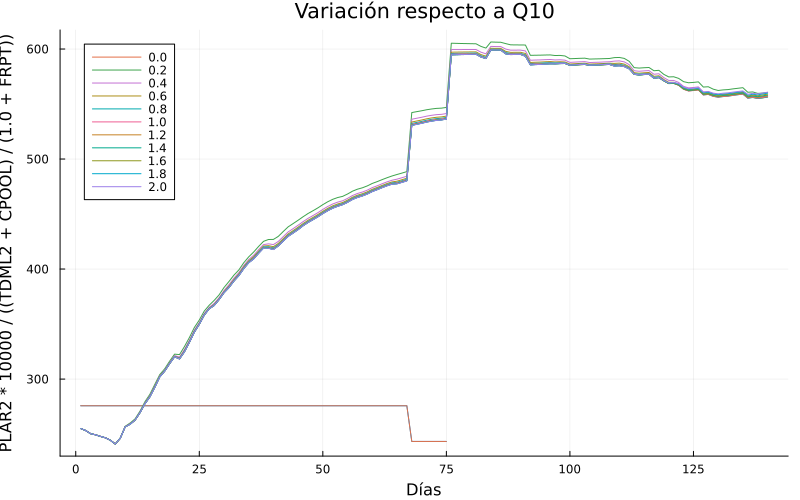

In [4]:
varpar = plot(TOMGROV2(0.0)[:,14],label=false, title="Variación respecto a Q10",xlabel="Días",ylabel="PLAR2 * 10000 / ((TDML2 + CPOOL) / (1.0 + FRPT))")
for i in 0.0:0.2:2.0
    varpar = plot!(TOMGROV2(i)[:,14],label=string(i))
end
plot(varpar,size=(800,500))

Sabiendo que los resultados se crearon con el valor de `Q10`$=1.4$, a este valor se le añade un ruido aditivo producido por una variable aleatoria normal con media en $0$ y desviación estándar $5$.

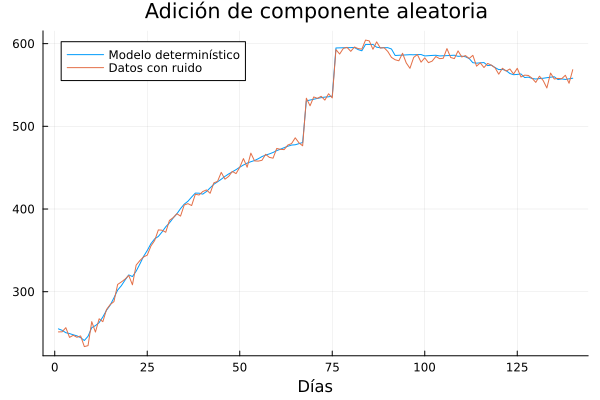

In [5]:
#Adición de ruido gaussiano
datosconruido = TOMGROV2(1.4)[:,14] + 5*randn(140);
#Diferencia gráfica entre el modelo determinístico y los datos con ruido
plot(TOMGROV2(1.4)[:,14],label="Modelo determinístico",title="Adición de componente aleatoria", xlabel="Días")
plot!(datosconruido,label="Datos con ruido")

Se crea la función de log-energía para el parámetro suponiendo que los datos siguen normalidad al igual que el parámetro. Además de esto, se crea una función soporte para acotar el valor del parámetro.

In [6]:
function energia(p) # log de la posterior
    noisy_data = datosconruido
    mu = TOMGROV2(p[1])[:,14]

    log_likelihood = sum(logpdf.(Normal.(mu,0.10), noisy_data))
    log_prior = logpdf(Normal(1.4,0.1), p[1])
    
    return 0.0001*(log_likelihood + 0.1*log_prior) + log(1E8)
end

function supp(p)
    if p[1]>=0.001 && p[1]<=3.0
        return true
    else
        return false
    end
end

supp (generic function with 1 method)

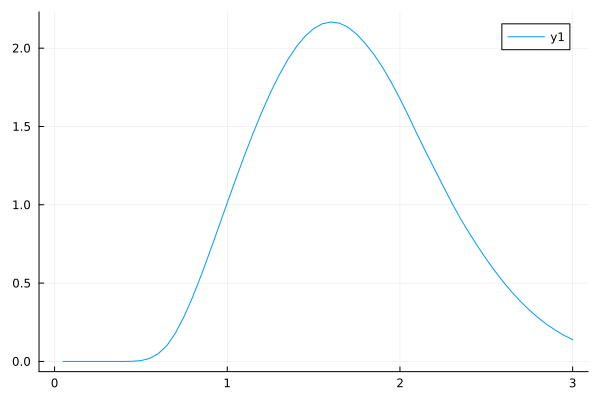

In [7]:
#Grafica de la función de energía
plot(0:0.05:3,exp.(energia.(0:0.05:3)))

In [14]:

# Algoritmo Metrópolis Hastings Random Walk

function MHRW0(np,logenergia,soporte,puntoincial,sd=0.1,iteraciones=1000)
    #np es el número de parámetros a estimar
    #Se usa logenergia para controlar posibles errores numéricos 
    #log energía solo debe depender del vector de parámetros 
    #sd: desviación estándar del camino aleatorio
    samples = rand(np) 
    probabilities = [exp(logenergia(samples[:,end]))]

    Alpha = [0] # tasa de aceptación
    #sd: desviación estándar del camino aleatorio

    # MHRW
    for i in 1:iteraciones
        # Construcción de nuevas muestras con un camino aleatorio normal
        theta = samples[:,end]+ sd*randn(np)
        # Condición del soporte
        if soporte(theta) == false
            alpha = 0
            p2 = exp(logenergia(samples[:,end]))
        else
            p1 = exp(logenergia(theta))
            p2 = exp(logenergia(samples[:,end]))
            alpha = min(1, p1/p2)
        end 

        
        Alpha = hcat(Alpha,alpha)
        u = rand()
        #Selección de muestras
        if u < alpha
            samples = hcat(samples, theta)
            probabilities = hcat(probabilities,p1)
        else
            samples = hcat(samples, samples[:,end])
            probabilities = hcat(probabilities,p2)
        end
    end
    #Sistematic sampling
    initial_position = floor(100*rand())
    leap = 20
    samples_ss = samples[:, Int(initial_position):leap:end]
    probabilities_ss = probabilities[Int(initial_position):leap:end];

    #Estimations
    max_prob, position_ss = findmax(probabilities_ss)
    Max_likelihood = samples_ss[:, position_ss]
    Mean = mean(samples_ss, dims=2)
    return (Max_likelihood,max_prob,Mean,samples_ss,probabilities_ss,Alpha)
end

#Función que muestra información gráfica de los resultados del algoritmo MHRW

function grafMHRW(set,init)
    Max_likelihood,max_prob,Mean,samples_ss,probabilities_ss,Alpha1 = set
    #Histograma
    p1 = histogram(samples_ss[1,:],bins=30,label=false,color="red",title="Histograma")
    p1 = plot!([Mean[1], Mean[1]], [0,10],linewidth=2,color="orange", label="Media Condicional")
    p1 = plot!([Max_likelihood[1], Max_likelihood[1]], [0,10],linewidth=2,color="green", label="Max a Posteriori")
    #Camino aleatorio
    p2 = plot(samples_ss[1,:],color="red",label = false,title="Camino aleatorio")
    #Log-verosimilitud
    p3 = plot(log.(probabilities_ss), label=false , title="Log-Verosimilitud")
    #Datos de partida
    p4 = plot(init,label="", title="Datos de partida")
    #MHRW
    p5 = plot(init,label=false, title="MHRW")
    for i in 1:3:(size(samples_ss)[2])
        p5 = plot!(TOMGROV2(samples_ss[1,i])[:,14],color="gray82",label=false)
    end
    p5 = plot!(init,label=false)
    p5 = plot!(TOMGROV2(Mean[1])[:,14],linewidth=1,color="orange", label="Media Condicional")
    p5 = plot!(TOMGROV2(Max_likelihood[1])[:,14],linewidth=1,color="green", label="Max a Posteriori")
    #Tasa de aceptación
    p6 = plot(Alpha1[1,:],title="Tasa de aceptación",label=false)

    #Gráfico
    plot(p1,p2,p3,p4,p5,p6,layout=(3,2),size=(1000,1200))
end

grafMHRW (generic function with 1 method)

In [10]:
resMH = MHRW0(1,energia,supp,1,0.01,2000)

([1.2948398334027662], 1.8164897164064477, [1.0446349699158453;;], [0.4053708423978331 0.45617780098022126 … 1.0316769521382925 1.0669417492002498], [9.679650285629777e-5, 0.0011740687256099943, 0.002759216123054322, 0.049888782505868395, 0.05902437941040054, 0.0437949900913007, 0.05785186081143096, 0.11271843332323397, 0.12351904023050833, 0.08067032342672106  …  1.0584150195607962, 0.9863905088937308, 0.8017732564667631, 1.0070332611088904, 1.2347679167546595, 1.1158155349380048, 1.0454865234249222, 1.0364437158286832, 1.1103733307652695, 1.217379537427979], [0.0 1.0 … 0.9803805722274903 1.0])

In [13]:
@show resMH[1][1]
@show resMH[3][1,1]

(resMH[1])[1] = 1.2948398334027662
(resMH[3])[1, 1] = 1.0446349699158453


1.0446349699158453

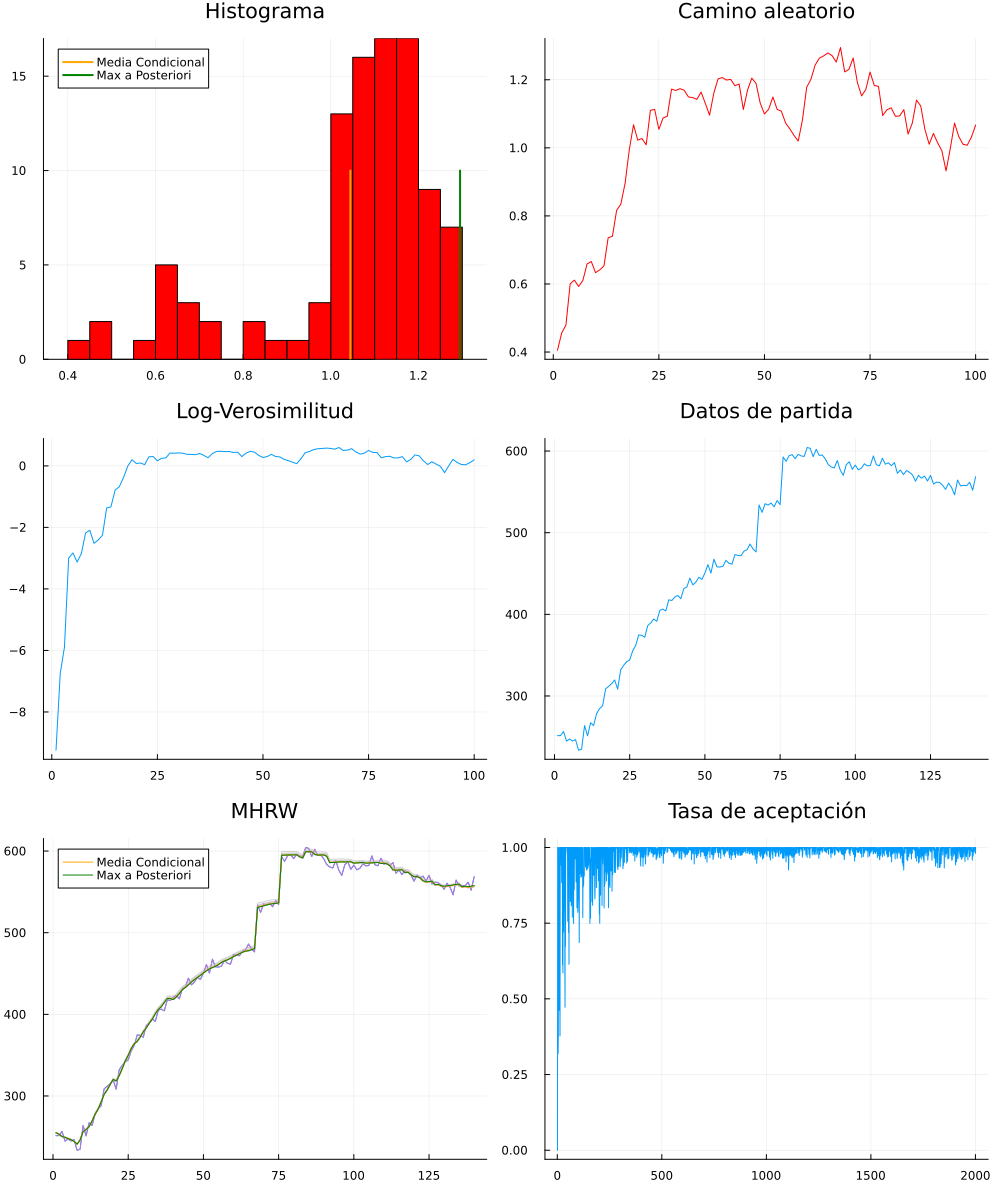

In [15]:
grafMHRW(resMH,datosconruido)